# Assignment 3 - Supervised Learning: Model Training and Evaluation

Emma Mavis

egm28

Worked with: Sydney Donati-Leach

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import random
from scipy.stats import itemfreq
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    log_loss,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# 1.

## Classification Using Logistic Regression: Build it From the Ground Up

### I. Load, prepare, and plot data

**(a)** Load and inspect the data for missing and erroneous values

In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/kylebradbury/ids705/main/assignments/data/A3_Q1_data.csv"
)


There are 0 missing values in this data set.
The outcome variable is balanced in its values: 51.5% are of Class 0, and the remaining 48.5% are of Class 1.


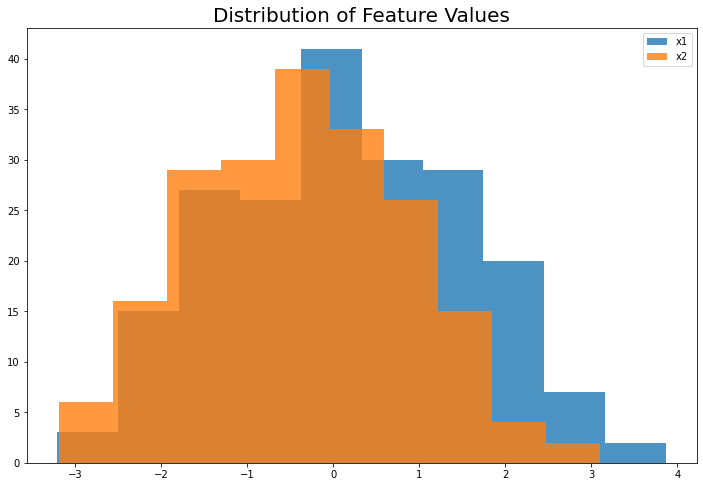

As seen in the above histogram, both feature variables appear to be normally distributed, and are on the same scale of values.


In [3]:
print(
    f"There are {sum((data.isna().any()))} missing values in this data"
    " set."
)
# no missing values
data.describe()
print(
    f"The outcome variable is balanced in its values: {sum(data.y==0)/2}%"
    f" are of Class 0, and the remaining {sum(data.y==1)/2}% are of"
    " Class 1."
)

plt.figure(figsize=(12, 8))
plt.hist(data.x1, alpha=0.8, label="x1")
plt.hist(data.x2, alpha=0.8, label="x2")
plt.title("Distribution of Feature Values", size=20)
plt.legend()
plt.show()

print(
    "As seen in the above histogram, both feature variables appear to be"
    " normally distributed, and are on the same scale of values."
)


**(b)** Divide into test and train and visualize training data set

In [21]:
training = data.sample(frac=0.7, random_state=10)
testing = data.drop(training.index)
print(
    f"Size of training data: {len(training)}\nSize of testing data:"
    f" {len(testing)}"
)


Size of training data: 140
Size of testing data: 60


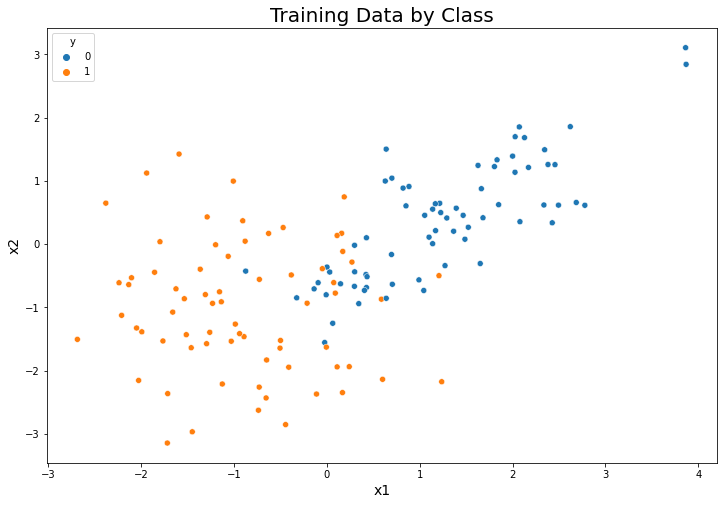

In [22]:
plt.figure(figsize=(12, 8))
p = sns.scatterplot(x=training.x1, y=training.x2, hue=training.y)
p.set_title("Training Data by Class", size=20)
p.set_xlabel("x1", size=14)
p.set_ylabel("x2", size=14)
plt.show()


The data do appear to be generally seperable. Logistic regression may be a good choice for classifying this data since the training data set displays a somewhat linear trend. But the linearity is quite weak, there is some more random clustering, especially among the Class 0 data points that might be benefitted by a KNN classifier. Clearer conclusions will be made after fitting and evaluation.

### II. Stating the hypothesis set of models to evaluate (logistic regression)
We will use logistic regression to model our data in a two-dimensional feature space.

### III. Find the cost function that we can use to choose the model parameters, **w**, that best fit the training data
In the following three sections, we will be:
- defining the likelihood function that corresponds to all $N$ samples in the training data, $L(\textbf{w} | \textbf{y}, \textbf{X})$
- taking the logarithm of the likelihood function and negating it to find the cost function, $C(\textbf{w}) = -\log L(\textbf{w} | \textbf{y}, \textbf{X})$
- minimizing the cost function using gradient descent, $\nabla_\textbf{w}C(\textbf{w})$

**(c)** Assuming that our observations are independent, the likelihood function that corresponds to all the $N$ samples in our training data set is,

$$
\begin{align*}
L(\textbf{w} | \textbf{y}, \textbf{X}) = P(y_1,y_2,...y_N | \textbf{x}_1, \textbf{x}_2,...,\textbf{x}_N) &= \prod_{i=1}^N P(y_i | \textbf{x}_i) \\
&= \prod_{i=1}^N P(y_i=1 | \textbf{x}_i)^{y_i}P(y_i = 0 | \textbf{x}_i)^{1 - y_i} \\
\end{align*}
$$

After substituting the sigmoid function in for the probability function, we arrive at,
$$
= \prod_{i=1}^N \sigma(\textbf{w}^\top\textbf{x}_i)^{y_i} [1 - \sigma(\textbf{w}^\top\textbf{x}_i)]^{1 - y_i}
$$

**(d)** We first take the logarithm of the likelihood function,

$$
\begin{align*}
\log L(\textbf{w} | \textbf{y}, \textbf{X}) &= \log \left\{\prod_{i=1}^N \sigma(\textbf{w}^\top\textbf{x}_i)^{y_i}[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]^{1 - y_i}\right\} \\
&= \sum_{i=1}^N \log\{\sigma(\textbf{w}^\top\textbf{x}_i)[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]^{1 - y_i}\} \\
&= \sum_{i=1}^N y_i\log\sigma(\textbf{w}^\top\textbf{x}_i) + (1 - y_i)\log[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]
\end{align*}
$$

Lastly, we negate the last equation from above and arrive at our cost function,

$$
C(\textbf{w}) = - \log L(\textbf{w} | \textbf{y}, \textbf{X}) = - \left\{ \sum_{i=1}^N y_i\log\sigma(\textbf{w}^\top\textbf{x}_i) + (1 - y_i)\log[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]\right\}
$$

**(e)** By calculating the gradient descent of the above equation - with respect to the model parameters, $\textbf{w}$ - we minimize the cost function,

$$
\begin{align*}
\nabla_\textbf{w}C(\textbf{w}) &= - \left\{\sum_{i=1}^N y_i \frac{1}{\sigma(\textbf{w}^\top\textbf{x}_i)}\sigma(\textbf{w}^\top\textbf{x}_i)[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]x_{ij} - (1 - y_i)\frac{1}{1 - \sigma(\textbf{w}^\top\textbf{x}_i)}[1 - \sigma(\textbf{w}^\top\textbf{x}_i)]\sigma(\textbf{w}^\top\textbf{x}_i)x_{ij}\right\} \\
&= - \left\{\sum_{i=1}^N y_ix_{ij}[1 - \sigma(\textbf{w}^\top\textbf{x}_i)] - (1 - y_i)x_{ij}\sigma(\textbf{w}^\top\textbf{x}_i)\right\} \\
&= - \left\{\sum_{i=1}^N y_ix_{ij} - x_{ij}\sigma(\textbf{w}^\top\textbf{x}_i)\right\} \\
&= \sum_{i=1}^N x_{ij}[\sigma(\textbf{w}^\top\textbf{x}_i) - y_i]
\end{align*}
$$


**(f)** The gradient descent update equation is,

$$
\begin{align*}
 w_j^{(k + 1)} &= w_j^{(k)} - \eta\nabla_\textbf{w}C(\textbf{w}) \\
 &= 
\begin{bmatrix}
w_0 \\ w_1 \\ w_2
\end{bmatrix}^{(k)}
- \eta 
\begin{bmatrix}
[\sigma(\textbf{w}^\top\textbf{x}_i) - y_i]x_{i,0} \\ [\sigma(\textbf{w}^\top\textbf{x}_i) - y_i]x_{i,1} \\ [\sigma(\textbf{w}^\top\textbf{x}_i) - y_i]x_{i,2}
\end{bmatrix}
\end{align*}
$$
for $i = 1, 2,...,N$ and where $\eta$ is the learning rate.

### IV. Implement gradient descent and logistic regression algorithm
**(g)** Implementation of logistic regression class

In [23]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        self.w = None  # logistic regression weights
        self.saved_w = (
            []
        )  # Since this is a small problem, we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves
        # returns nothing
        pass

    # Appends a column of ones as the first feature to account for the bias term
    def prepare_x(self, X):
        # returns the X with a new feature of all ones (a column that is the new column 0)
        return np.c_[np.ones(X.shape[0]), X]

    # Method for calculating the sigmoid function of w^T X for an input set of weights
    def sigmoid(self, X, w):
        # returns the value of the sigmoid
        # X = self.prepare_x(X)
        z = np.matmul(w.transpose(), X.transpose())
        sig = np.exp(z) / (1 + np.exp(z))
        return sig

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        # returns the average cross entropy cost
        N = len(y)
        sig = self.sigmoid(X, w)
        cost = -(1 / N) * (
            np.matmul(y, np.log(sig)) + np.matmul((1 - y), np.log(1 - sig))
        )
        return cost

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        # returns s scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        sig = self.sigmoid(X, self.w)
        delta = np.matmul(X.transpose(), (sig.transpose() - y))
        self.w = self.w - (lr * delta)
        return np.linalg.norm(lr * delta)

    # Fit the logistic regression model to the data through gradient descent
    def fit(
        self,
        X,
        y,
        w_init,
        lr,
        delta_thresh=1e-6,
        max_iter=5000,
        verbose=False,
    ):
        # Note the verbose flag enables you to print out the weights at each iteration
        #  (optional - but may help with one of the questions)

        self.w = w_init
        # self.saved_w.append(w_init)
        delta = 10
        iterator = 1
        while iterator <= max_iter and delta >= delta_thresh:
            delta = self.gradient_descent(X, y, lr)
            self.saved_w.append(self.w)
            iterator += 1
            if verbose:
                print(self.w)

        # returns nothing
        pass

    # Use the trained model to predict the confidence scores (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        return self.sigmoid(X, self.w)

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        # returns a binary prediction for each sample
        return (self.predict_proba(X) > 0.5).astype("int")

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):
        # returns the value of the cost function from each step in gradient descent
        #  from the last model fitting process
        cost_values = []
        for w in self.saved_w:
            cost_values.append(self.cost(X, y, w))
        return cost_values


**(h)** Cost as a function of each iteration of gradient descent for test and train data

In [24]:
# grab the predictors and class labels from both the training and testing data sets
# initialize weight values
x_train = np.array(training)[:, 0:2]
y_train = np.array(training)[:, 2]
x_test = np.array(testing)[:, 0:2]
y_test = np.array(testing)[:, 2]
w_init = np.array([1, 1, 1])


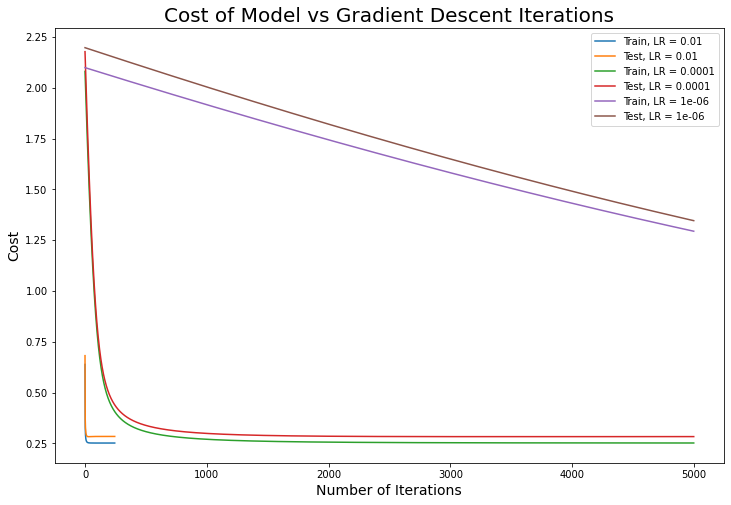

In [25]:
lr = np.array([1e-2, 1e-4, 1e-6])
plt.figure(figsize=(12, 8))
for i in range(len(lr)):
    model = Logistic_regression()
    x_train_prepared = model.prepare_x(x_train)
    x_test_prepared = model.prepare_x(x_test)
    model.fit(x_train_prepared, y_train, w_init, lr[i])
    train_cost = model.learning_curve(x_train_prepared, y_train)
    test_cost = model.learning_curve(x_test_prepared, y_test)

    plt.plot(
        range(len(train_cost)), train_cost, label=f"Train, LR = {lr[i]}"
    )
    plt.plot(range(len(test_cost)), test_cost, label=f"Test, LR = {lr[i]}")

plt.legend()
plt.xlabel("Number of Iterations", size=14)
plt.ylabel("Cost", size=14)
plt.title("Cost of Model vs Gradient Descent Iterations", size=20)
plt.show()


In [26]:
# running model on really big learning rate
model = Logistic_regression()
x_train_prepared = model.prepare_x(x_train)
x_test_prepared = model.prepare_x(x_test)
model.fit(x_train_prepared, y_train, w_init, 1, max_iter=150)


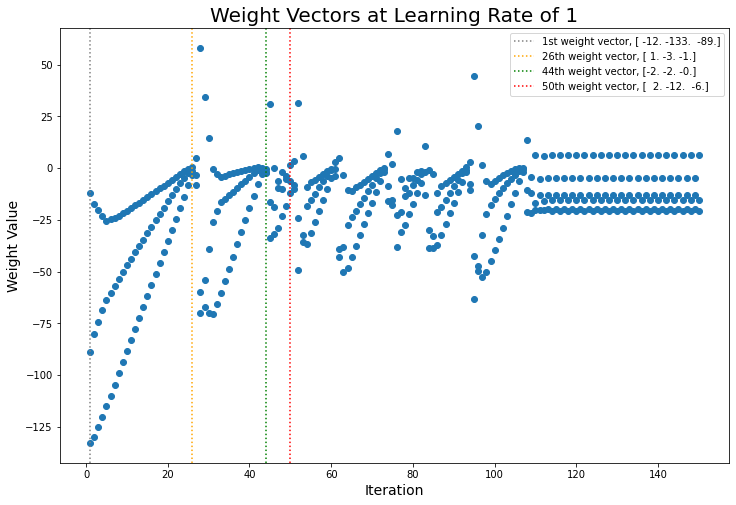

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(np.repeat(range(1, 151), 3), model.saved_w)
plt.axvline(
    x=1,
    color="gray",
    linestyle=":",
    label=f"1st weight vector, {np.round(model.saved_w[0],0)}",
)
plt.axvline(
    x=26,
    color="orange",
    linestyle=":",
    label=f"26th weight vector, {np.round(model.saved_w[25],0)}",
)
plt.axvline(
    x=44,
    color="green",
    linestyle=":",
    label=f"44th weight vector, {np.round(model.saved_w[43],0)}",
)
plt.axvline(
    x=50,
    color="red",
    linestyle=":",
    label=f"50th weight vector, {np.round(model.saved_w[49],0)}",
)
plt.title("Weight Vectors at Learning Rate of 1", size=20)
plt.xlabel("Iteration", size=14)
plt.ylabel("Weight Value", size=14)
plt.legend()
plt.show()


- With a learning rate of 1, the weights appear to "converge" at similar values (at least within 50 iterations) twice. Indeed, we see in the above visualization that for up to 150 iterations, it appears the learned weights repeat the learning process multiple times until they level out to constant values. This is because a high learning rate has a hard and often impossible time finding the weights with the lowest cost, i.e. it "overshoots" the mark and can never find that optimal value to minimize cost
-  The smaller the learning value is, the longer it takes to reach the optimal weights. This means that the fitting process takes much longer to complete, and as seen in the cost vs gradient descent plot, a learning rate of 1e-6 did not even minimize cost within 5,000 iterations. The larger learning rates take much faster to complete, and indeed the fitting process for the learning rate of 1e-2 completed in less than 500 iterations. This is good, but again we must be careful because with too large of a learning rate we could overshoot the optimal weights and never find them
- Of the options explored in this problem, I prefer the learning rate of 1e-2. It found the weights associated with the smallest cost in the shortest amount of time.

### V. Evaluate model performance through cross validation
**(i)** Test performance of trained classifier using K-folds cross validation

In [28]:
# train logistic classifer and knn classifier with k = 7
log = Logistic_regression()
log.fit(x_train_prepared, y_train, w_init, 1e-2)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train_prepared, y_train)


KNeighborsClassifier(n_neighbors=7)

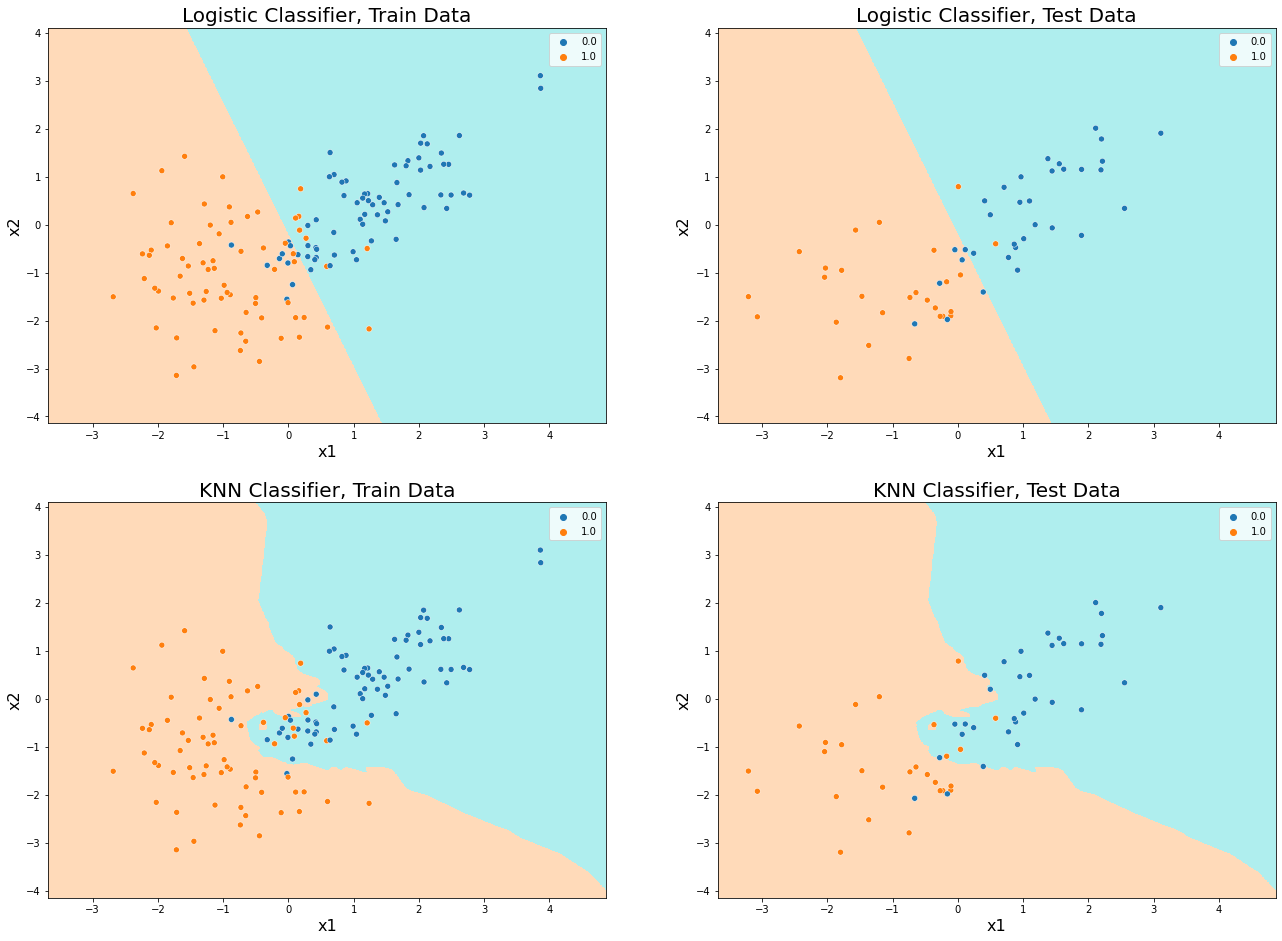

In [29]:
# plot the models
fig, axes = plt.subplots(2, 2, figsize=(22, 16))

# create meshgrid
cmap_light = ListedColormap(["paleturquoise", "peachpuff"])
h = 0.01
x0_min, x0_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
x1_min, x1_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx0, xx1 = np.meshgrid(
    np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h)
)
Z = np.c_[xx0.ravel(), xx1.ravel()]

# decision boundary for logistic model
Z_prepared = log.prepare_x(Z)
log_boundary = log.predict(Z_prepared).reshape(xx0.shape)
# train
axes[0, 0].contourf(xx0, xx1, log_boundary, cmap=cmap_light)
s1 = sns.scatterplot(
    ax=axes[0, 0], x=x_train[:, 0], y=x_train[:, 1], hue=y_train
)
s1.set_title("Logistic Classifier, Train Data", size=20)
s1.set_xlabel("x1", size=16)
s1.set_ylabel("x2", size=16)
# test
axes[0, 1].contourf(xx0, xx1, log_boundary, cmap=cmap_light)
s2 = sns.scatterplot(
    ax=axes[0, 1], x=x_test[:, 0], y=x_test[:, 1], hue=y_test
)
s2.set_title("Logistic Classifier, Test Data", size=20)
s2.set_xlabel("x1", size=16)
s2.set_ylabel("x2", size=16)

# decision boundary for knn model
knn_boundary = knn.predict(Z_prepared).reshape(xx0.shape)
# train
axes[1, 0].contourf(xx0, xx1, knn_boundary, cmap=cmap_light)
s3 = sns.scatterplot(
    ax=axes[1, 0], x=x_train[:, 0], y=x_train[:, 1], hue=y_train
)
s3.set_title("KNN Classifier, Train Data", size=20)
s3.set_xlabel("x1", size=16)
s3.set_ylabel("x2", size=16)
# test
axes[1, 1].contourf(xx0, xx1, knn_boundary, cmap=cmap_light)
s4 = sns.scatterplot(
    ax=axes[1, 1], x=x_test[:, 0], y=x_test[:, 1], hue=y_test
)
s4.set_title("KNN Classifier, Test Data", size=20)
s4.set_xlabel("x1", size=16)
s4.set_ylabel("x2", size=16)

plt.show()


In [16]:
# compute cross validation performance of each classifier

cv = StratifiedKFold(n_splits=10)
log_predictions = []
knn_predictions = []
log_probabilities = []
knn_probabilities = []
log_roc_auc = []
knn_roc_auc = []
y_test_list = []
X = data[["x1", "x2"]].values
y = data[["y"]].values.ravel()

for train_index, test_index in cv.split(X, y):
    # split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_test_list.append(y_test)
    # initialize the models
    log_model = Logistic_regression()
    knn_model = KNeighborsClassifier(n_neighbors=7)
    X_train_prepared = log_model.prepare_x(X_train)
    X_test_prepared = log_model.prepare_x(X_test)

    # fit the models
    log_model.fit(X_train_prepared, y_train, w_init, 1e-2)
    knn_model.fit(X_train, y_train)

    log_predictions.append(log_model.predict(X_test_prepared))
    knn_predictions.append(knn_model.predict(X_test))

    log_probabilities.append(log_model.predict_proba(X_test_prepared))
    knn_probabilities.append(
        np.array(knn_model.predict_proba(X_test)[:, 1])
    )


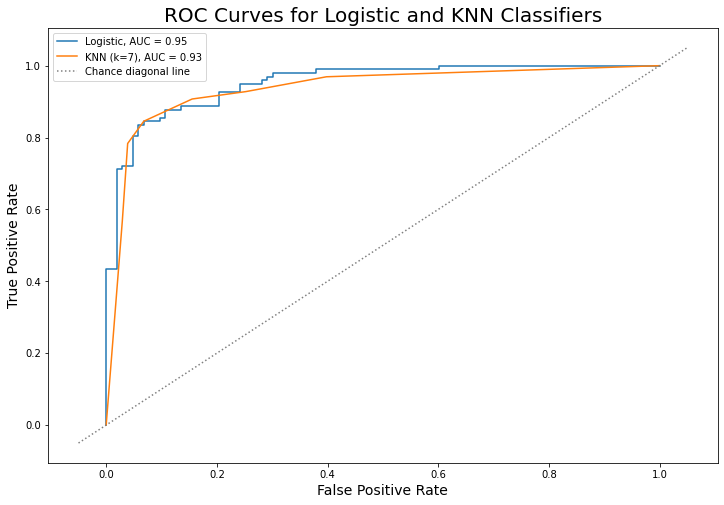

In [41]:
# plot ROC curves for each classifier

log_all_probabilities = np.array(log_probabilities).flatten()
knn_all_probabilities = np.array(knn_probabilities).flatten()
y_test_all = np.array(y_test_list).flatten()
fpr_log, tpr_log, threshold_log = roc_curve(
    y_test_all, log_all_probabilities
)
fpr_knn, tpr_knn, threshold_knn = roc_curve(
    y_test_all, knn_all_probabilities
)

# calculate AUC
auc_log = auc(fpr_log, tpr_log)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(12, 8))
plt.plot(fpr_log, tpr_log, label=f"Logistic, AUC = {auc_log:.2f}")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (k=7), AUC = {auc_knn:.2f}")
# chance diagonal line
xpoints = ypoints = plt.xlim()
plt.plot(
    xpoints,
    ypoints,
    linestyle=":",
    color="gray",
    label="Chance diagonal line",
)
plt.title("ROC Curves for Logistic and KNN Classifiers", size=20)
plt.xlabel("False Positive Rate", size=14)
plt.ylabel("True Positive Rate", size=14)
plt.legend()
plt.show()


- The purpose of using cross-validation for this problem is to prevent overfitting to the training data, and to find the bess hyperparameters. In this case, we would use cross-validation to find the best learning rate for logistic regression and the best $k$-value for KNN.
- The models performed very similarly to each other, with the logistic classifier having just a slightly greater AUC than the KNN classifier. The KNN decision boundary appears to match the pattern seen in this data set best, but that could present problems in the future if unseen data doesn't match the overlap in classes we see in this instance. Therefore, I would choose logistic regression to use on unseen data because it is a less variant model and could potentially fit future data that maintains the mostly linear decision boundary. 

# 2.

## Digits Classification

In [42]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pickle

# Set this to True to download the data for the first time and False after the first time
#   so that you just load the data locally instead
download_data = False  # already ran once

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y != "3"] = 0
    y[y == "3"] = 1
    y = y.astype("int")

    # Divide the data intro a training and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 / 7, random_state=88
    )

    file = open("tmpdata", "wb")
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open("tmpdata", "rb")
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()


**(a)** Plot 10 examples of each class from training data

In [43]:
# reshape data so digits can be visualized
plot_X_train = X_train.reshape([60000, 28, 28])


In [44]:
# get 10 random samples from each class
class_0 = plot_X_train[y_train == 0]
class_1 = plot_X_train[y_train == 1]

random.seed(3)

indeces_0 = random.sample(range(class_0.shape[0]), 10)
indeces_1 = random.sample(range(class_1.shape[0]), 10)
sample_0 = class_0[indeces_0]
sample_1 = class_1[indeces_1]


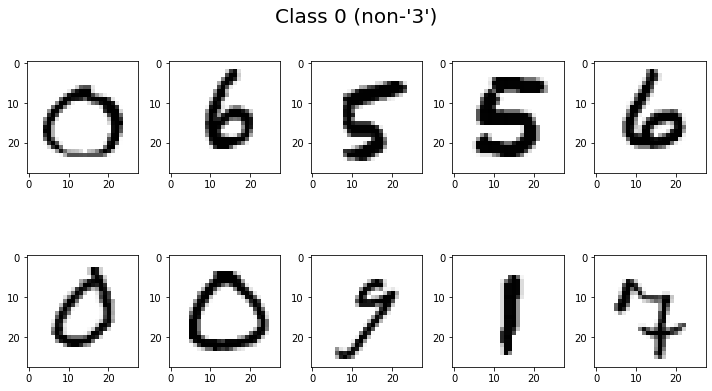

In [45]:
# class 0
num = 10
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(10, 6))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(sample_0[i], cmap="gray_r")
plt.tight_layout()
plt.suptitle("Class 0 (non-'3')", size=20)
plt.show()


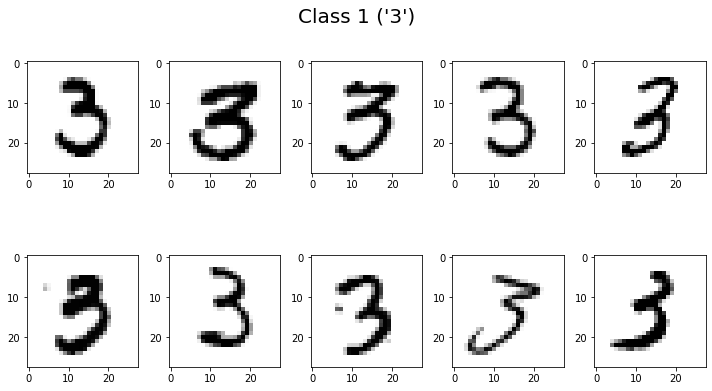

In [46]:
# class 1
fig, axes = plt.subplots(num_row, num_col, figsize=(10, 6))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(sample_1[i], cmap="gray_r")
plt.tight_layout()
plt.suptitle("Class 1 ('3')", size=20)
plt.show()


**(b)** Number of samples in each class

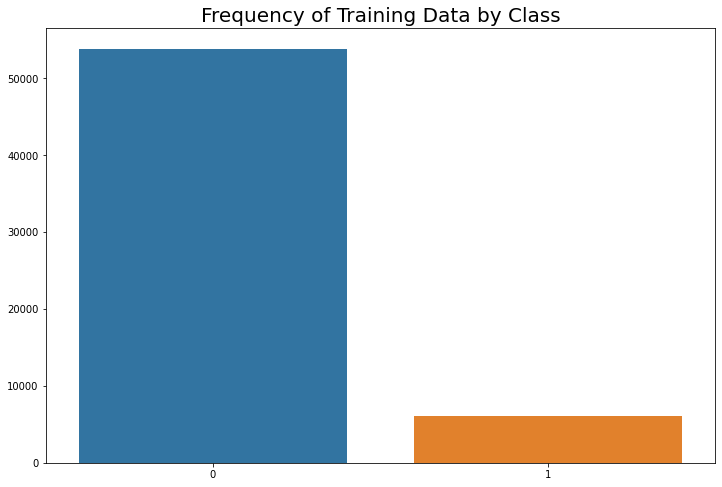

There are 53871 observations of Class 0, and 6129 observations of Class 1. This means that 10.215% of the samples are postive. This presents an issue of extreme inbalance in our analysis - a higher weight will be placed on Class 0 which could potentially misclassify unseen data.


In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(itemfreq(y_train).T[0], itemfreq(y_train).T[1])
plt.title("Frequency of Training Data by Class", size=20)
plt.show()
print(
    f"There are {sum(y_train==0)} observations of Class 0, and"
    f" {sum(y_train==1)} observations of Class 1. This means that"
    f" {sum(y_train==1)/len(y_train)*100}% of the samples are postive."
    " This presents an issue of extreme inbalance in our analysis - a"
    " higher weight will be placed on Class 0 which could potentially"
    " misclassify unseen data."
)


**(c)** Implementation of logistic regression classifier with lasso regularization

In [48]:
# generate 20 different values of regularization strength
random.seed(10)
C = np.logspace(-4, 4, 20)

non_zero_coeff = []
f1_scores = []
cross_entropy_losses = []
auc_values = []

for c in C:
    lasso_model = LogisticRegression(
        penalty="l1", C=c, solver="liblinear"
    ).fit(X_train, y_train)
    # need to grab the probabilities of just Class 1
    predictions = lasso_model.predict_proba(X_test)[:, 1]
    # grab the count of non-zero coefficients
    non_zero_coeff.append(len(lasso_model.coef_[lasso_model.coef_ != 0]))
    # grab the log loss
    cross_entropy_losses.append(log_loss(y_test, predictions))
    # grab the f1 score associated with a threshold probability of 0.5
    f1_scores.append(f1_score(y_test, predictions > 0.5))
    # calculate ROC curve metrics
    fpr, tpr, threshold = roc_curve(y_test, predictions, pos_label=1)
    # use ROC curve metrics to calculate AUC
    auc_values.append(auc(fpr, tpr))


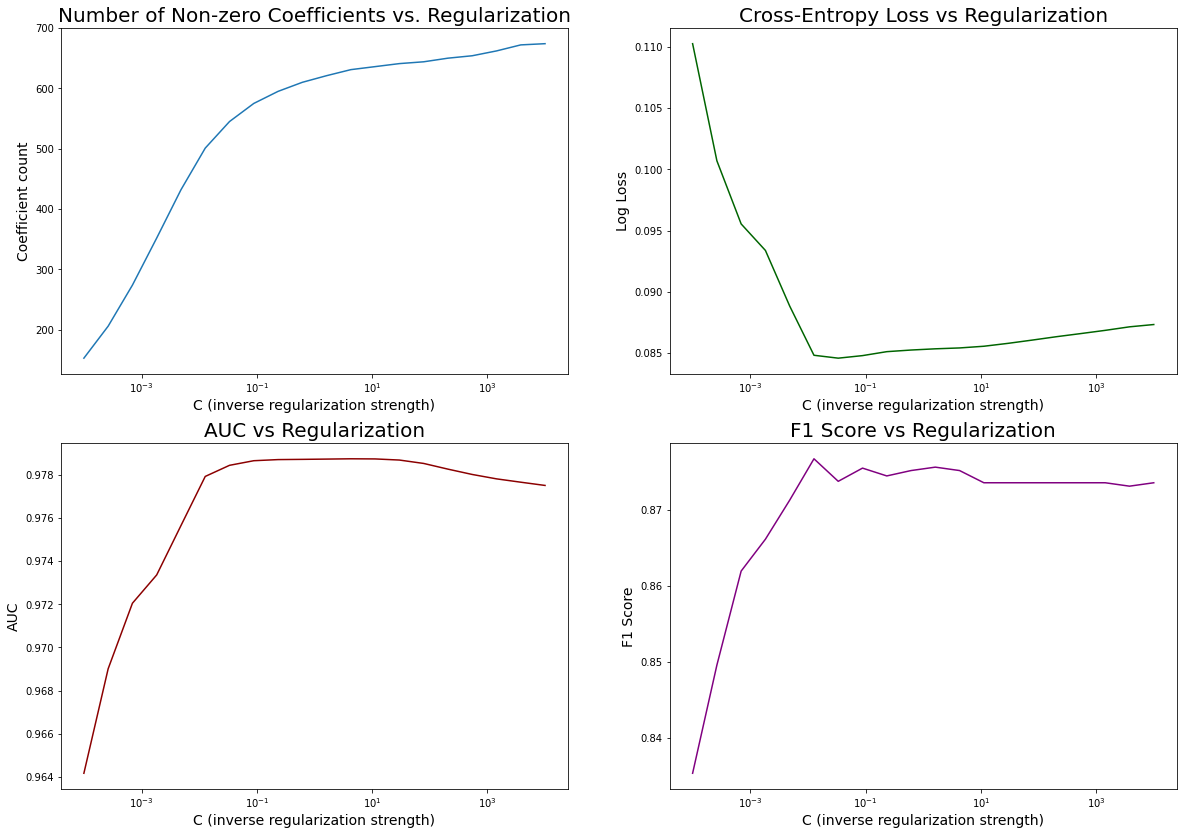

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20, 14))
one = ax[0, 0]
two = ax[0, 1]
three = ax[1, 0]
four = ax[1, 1]

# coef
one.plot(C, non_zero_coeff)
one.set_xscale("log")
one.set_title(
    "Number of Non-zero Coefficients vs. Regularization", size=20
)
one.set_xlabel("C (inverse regularization strength)", size=14)
one.set_ylabel("Coefficient count", size=14)

# loss
two.plot(C, cross_entropy_losses, color="darkgreen")
two.set_xscale("log")
two.set_title("Cross-Entropy Loss vs Regularization", size=20)
two.set_xlabel("C (inverse regularization strength)", size=14)
two.set_ylabel("Log Loss", size=14)

# AUC
three.plot(C, auc_values, color="darkred")
three.set_xscale("log")
three.set_title("AUC vs Regularization", size=20)
three.set_xlabel("C (inverse regularization strength)", size=14)
three.set_ylabel("AUC", size=14)

# f1 score
four.plot(C, f1_scores, color="purple")
four.set_xscale("log")
four.set_title("F1 Score vs Regularization", size=20)
four.set_xlabel("C (inverse regularization strength)", size=14)
four.set_ylabel("F1 Score", size=14)
plt.show()


Based upon a visual inspection of these plots, the best $C$ value appears to be $C \sim 10^{-2}$. At this value of $C$, we have minimum loss, a relatively high AUC, and a maximum F1 score.

**(d)** Comparison of (1) logistic classifier with minimum regularization, (2) logistic classifier with best regularization, (3) LDA classifier, (4) RF classifier

In [51]:
# fit each classifier
log_min = LogisticRegression(
    penalty="l1", C=10 ** 100, solver="liblinear"
).fit(X_train, y_train)
log_best = LogisticRegression(
    penalty="l1", C=10 ** -2, solver="liblinear"
).fit(X_train, y_train)
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)


In [52]:
# generate predictions
logmin_predic = log_min.predict_proba(X_test)[:, 1]
logbest_predic = log_best.predict_proba(X_test)[:, 1]
lda_predic = lda.predict_proba(X_test)[:, 1]
rf_predic = rf.predict_proba(X_test)[:, 1]


In [53]:
# metrics for logmin
fpr1, tpr1, threshold1 = roc_curve(y_test, logmin_predic, pos_label=1)
precision1, recall1, thresholds1 = precision_recall_curve(
    y_test, logmin_predic
)
# metrics for logbest
fpr2, tpr2, threshold2 = roc_curve(y_test, logbest_predic, pos_label=1)
precision2, recall2, thresholds2 = precision_recall_curve(
    y_test, logbest_predic
)
# metriccs for lda
fpr3, tpr3, threshold3 = roc_curve(y_test, lda_predic, pos_label=1)
precision3, recall3, thresholds3 = precision_recall_curve(
    y_test, lda_predic
)
# metrics for rf
fpr4, tpr4, threshold4 = roc_curve(y_test, rf_predic, pos_label=1)
precision4, recall4, thresholds4 = precision_recall_curve(
    y_test, rf_predic
)


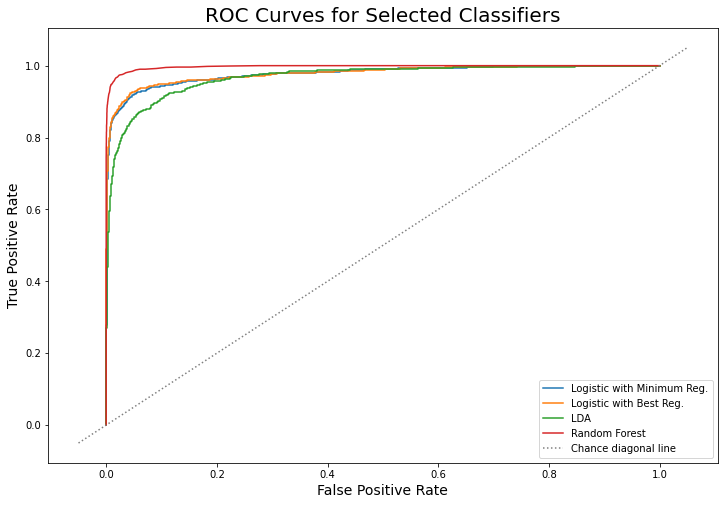

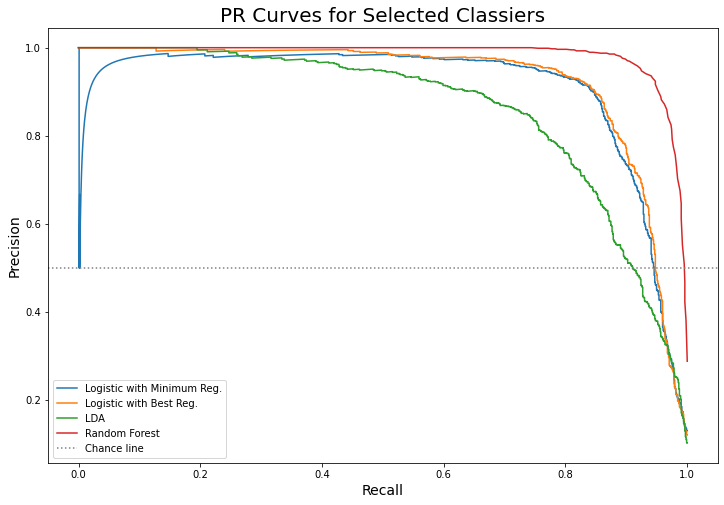

In [54]:
# ROC
plt.figure(figsize=(12, 8))

# logmin
plt.plot(fpr1, tpr1, label="Logistic with Minimum Reg.")
# logbest
plt.plot(fpr2, tpr2, label="Logistic with Best Reg.")
# lda
plt.plot(fpr3, tpr3, label="LDA")
# rf
plt.plot(fpr4, tpr4, label="Random Forest")
# random guess line
xpoints = ypoints = plt.xlim()
plt.plot(
    xpoints,
    ypoints,
    linestyle=":",
    color="gray",
    label="Chance diagonal line",
)
plt.legend()
plt.title("ROC Curves for Selected Classifiers", size=20)
plt.xlabel("False Positive Rate", size=14)
plt.ylabel("True Positive Rate", size=14)
plt.show()

# PR
plt.figure(figsize=(12, 8))

# logmin
plt.plot(recall1, precision1, label="Logistic with Minimum Reg.")
# logbest
plt.plot(recall2, precision2, label="Logistic with Best Reg.")
# lda
plt.plot(recall3, precision3, label="LDA")
# rf
plt.plot(recall4, precision4, label="Random Forest")
# chance line
plt.axhline(y=0.5, color="gray", linestyle=":", label="Chance line")
plt.legend()
plt.title("PR Curves for Selected Classiers", size=20)
plt.xlabel("Recall", size=14)
plt.ylabel("Precision", size=14)
plt.show()


Based upon the above curves, the random forest classifier performed the best. Linear discriminant analysis had the poorest performance, and both logistic regression models had mid-level performance. It also appears that the choice of regularization for the logistic regression (either the minimum value or the best value) did not make much difference in performance capabilities. I would choose the random forest classifier to apply to unseen data, as it has the highest values of precision, recall, and true postive rates.